# CNN

Inspired by:
- https://tf.keras.io/examples/timeseries/timeseries_classification_from_scratch/

## Set-up

In [1]:
import sys, os
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

2023-08-09 15:27:55.897568: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-09 15:27:55.901403: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 15:27:55.973923: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 15:27:55.974782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 15:27:57.205287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def singleGraph(df):
    fig = go.Figure()
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col))
    return fig

def tripleGraph(df, fig_title="Test"):
    col_num = 1
    fig = make_subplots(rows=1, cols=3)
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col), row=1, col=col_num)
      col_num += 1
    fig.update_layout(height=1080/2, width=1920/2, title_text=fig_title)
    return fig

def tripleGraph_vertical(df, fig_title="Test"):
    row_num = 1
    fig = make_subplots(rows=3, cols=1)
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col), row=row_num, col=1)
      row_num += 1
    fig.update_layout(height=1920/2, width=1080/2, title_text=fig_title)
    return fig

def comparaisonGraph(df1, df2, fig_title="Test"):    
    col_num = 1
    fig = make_subplots(rows=2, cols=3)
    for col in df1.columns:
        fig.add_trace(go.Scatter(x=df1.index,y=df1[col],name=col), row=1, col=col_num)
        fig.add_trace(go.Scatter(x=df2.index,y=df2[col],name=col), row=2, col=col_num)
        col_num += 1
    fig.update_layout(height=1080/2, width=1920/2, title_text=fig_title)
    return fig

def comparaisonGraph_vertical(df1, df2, fig_title="Test"):    
    row_num = 1
    fig = make_subplots(rows=3, cols=2)
    for col in df1.columns:
        fig.add_trace(go.Scatter(x=df1.index,y=df1[col],name=col), row=row_num, col=1)
        fig.add_trace(go.Scatter(x=df2.index,y=df2[col],name=col), row=row_num, col=2)
        row_num += 1
    fig.update_layout(height=1920/2, width=1080/2, title_text=fig_title)
    return fig

In [3]:
SEPARATOR = ";"

DATE = "2023_04_14"
DATA_FOLDER = os.path.join("../data/android_app/", DATE)

DATA_FILES = [file for file in os.listdir(DATA_FOLDER) if os.path.isfile(os.path.join(DATA_FOLDER, file)) and file.endswith(".txt")]
NB_DATA_FILES = len(DATA_FILES)

MAX_LENGTH = -1

for file in DATA_FILES:
    df = pd.read_csv(os.path.join(DATA_FOLDER, file), sep=SEPARATOR, header=None, names=["ay", "ax", "az"])
    if df.shape[0] > MAX_LENGTH:
        MAX_LENGTH = df.shape[0]

In [4]:
MAX_LENGTH

9489

## Load Data

In [5]:
acc_data = np.empty(shape=[NB_DATA_FILES, 3, MAX_LENGTH])

i = 0
for file in DATA_FILES:
    df = pd.read_csv(os.path.join(DATA_FOLDER, file), sep=SEPARATOR, header=None, names=["ay", "ax", "az"])
    acc = np.array([df["ax"], df["ay"], df["az"]])
    if acc.shape[1] < MAX_LENGTH:
        empty_cols = np.zeros((3, MAX_LENGTH - acc.shape[1]))
        empty_cols[2,:] = 9.81
        acc = np.append(acc, empty_cols, axis=1)
    acc_data[i] = acc
    i += 1

print(type(acc_data))
print(acc_data.shape)
print(acc_data)

<class 'numpy.ndarray'>
(1312, 3, 9489)
[[[ 0.0714304   0.14813458  0.1030584  ...  0.          0.
    0.        ]
  [-0.37641896 -0.26378161 -0.36190198 ...  0.          0.
    0.        ]
  [10.11775497 10.08741806  9.83627094 ...  9.81        9.81
    9.81      ]]

 [[ 0.03099807  0.03528728 -0.02902854 ...  0.          0.
    0.        ]
  [ 0.30884906  0.21094592  0.25264161 ...  0.          0.
    0.        ]
  [ 9.98530508 10.28351432  9.67408344 ...  9.81        9.81
    9.81      ]]

 [[ 0.43428437  0.36477921  0.40375223 ...  0.          0.
    0.        ]
  [-0.42338535 -0.32411449 -0.43140629 ...  0.          0.
    0.        ]
  [ 9.83885079  9.820853    9.91391092 ...  9.81        9.81
    9.81      ]]

 ...

 [[ 0.20808427  0.24666906  0.26158501 ...  0.          0.
    0.        ]
  [ 0.41867261  0.54033762  0.6115316  ...  0.          0.
    0.        ]
  [ 9.76221482  9.6235663   9.69275147 ...  9.81        9.81
    9.81      ]]

 [[ 0.05944742 -0.05591199 -0.11172798

## Load Labels

In [6]:
labels = pd.read_csv(os.path.join(DATA_FOLDER, DATE + ".labels"), sep=",", header=0)
labels = labels.values

acc_data_labels = np.empty(shape=[NB_DATA_FILES, 2], dtype=object)

for i in range(NB_DATA_FILES):
    file = DATA_FILES[i]
    acc_data_labels[i][0] = file
    for j in range(labels.shape[0]):
        if file.startswith(labels[j][0][:-4]):
            acc_data_labels[i][1] = labels[j][1]

# print(type(acc_data_labels))
# print(acc_data_labels.shape)
# print(acc_data_labels)

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(acc_data_labels[:,1])
acc_data_labels[:,1] = encoded_labels

print(type(acc_data_labels))
print(acc_data_labels.shape)
print(acc_data_labels)

<class 'numpy.ndarray'>
(1312, 2)
[['DATA11_ri_n.txt' 1]
 ['DATA51_n.txt' 1]
 ['DATA70_i_n.txt' 3]
 ...
 ['DATA36_m_n.txt' 6]
 ['DATA51_r_n.txt' 1]
 ['DATA74_ri_m.txt' 3]]


In [7]:
NUM_CLASSES = len(np.unique(acc_data_labels[:,1]))

print(NUM_CLASSES)

7


## Visualize Data

In [8]:
df = pd.DataFrame(acc_data[0].transpose())
df
tripleGraph(df, acc_data_labels[0][0])

In [9]:
data = pd.read_csv(os.path.join(DATA_FOLDER, "DATA40.txt"), sep=SEPARATOR, header=1, names=["ay", "ax", "az"])
tripleGraph(data)

## Create Train/Test Datasets

In [10]:
idx = np.random.permutation(NB_DATA_FILES)
acc_data = acc_data[idx]
acc_data_labels = acc_data_labels[idx]

# print(acc_data)
# print(acc_data_labels)

In [11]:
TRAIN_PERCENTAGE = 70

NB_TRAIN = int((TRAIN_PERCENTAGE * NB_DATA_FILES) / 100)

print(NB_DATA_FILES)
print(NB_TRAIN)

1312
918


In [12]:
x_train, y_train = acc_data[:NB_TRAIN], acc_data_labels[:NB_TRAIN]
x_test, y_test = acc_data[NB_TRAIN:], acc_data_labels[NB_TRAIN:]

In [13]:
# Shuffle training set -> validation_split later
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

## Build Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 9489)]         0         
                                                                 
 conv1d (Conv1D)             (None, 3, 64)             1821952   
                                                                 
 batch_normalization (Batch  (None, 3, 64)             256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 3, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 64)             12352     
                                                                 
 batch_normalization_1 (Bat  (None, 3, 64)             256       
 chNormalization)                                            

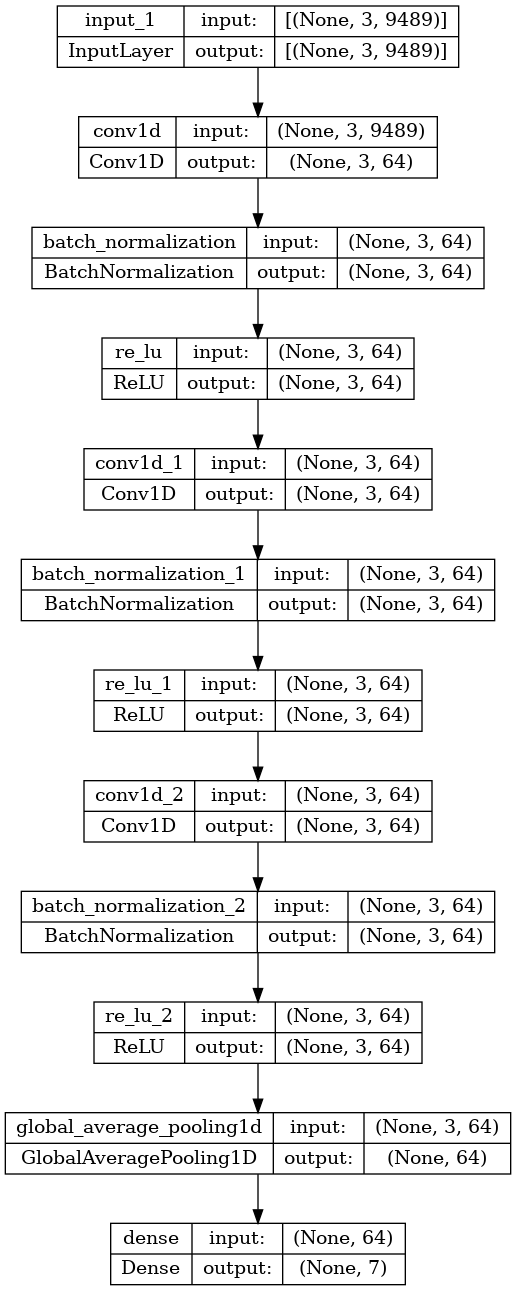

In [14]:
def make_model(input_shape, num_classes):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:], num_classes=NUM_CLASSES)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)


## Train Model

In [15]:
EPOCHS = 500
BATCH_SIZE = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    np.asarray(y_train[:,1]).astype("short"),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500
23/23 [==============================] - 4s 66ms/step - loss: 1.9453 - sparse_categorical_accuracy: 0.2084 - val_loss: 2.2059 - val_sparse_categorical_accuracy: 0.1630 - lr: 0.0010
Epoch 2/500
 1/23 [>.............................] - ETA: 0s - loss: 1.6973 - sparse_categorical_accuracy: 0.4062

/home/fabien/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



23/23 [==============================] - 1s 51ms/step - loss: 1.6377 - sparse_categorical_accuracy: 0.3501 - val_loss: 1.8911 - val_sparse_categorical_accuracy: 0.2609 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 1s 52ms/step - loss: 1.3756 - sparse_categorical_accuracy: 0.5150 - val_loss: 1.8731 - val_sparse_categorical_accuracy: 0.1630 - lr: 0.0010
Epoch 4/500
23/23 [==============================] - 1s 47ms/step - loss: 1.1776 - sparse_categorical_accuracy: 0.6512 - val_loss: 1.8726 - val_sparse_categorical_accuracy: 0.5870 - lr: 0.0010
Epoch 5/500
23/23 [==============================] - 1s 51ms/step - loss: 0.8365 - sparse_categorical_accuracy: 0.7956 - val_loss: 1.7602 - val_sparse_categorical_accuracy: 0.2609 - lr: 0.0010
Epoch 6/500
23/23 [==============================] - 1s 43ms/step - loss: 0.3909 - sparse_categorical_accuracy: 0.9755 - val_loss: 1.8192 - val_sparse_categorical_accuracy: 0.2609 - lr: 0.0010
Epoch 7/500
23/23 [============================

## Evaluate Model

In [16]:
model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, np.asarray(y_test[:,1]).astype("short"))

print("Test accuracy", test_acc)
print("Test loss", test_loss)


13/13 [==============================] - 0s 10ms/step - loss: 0.0885 - sparse_categorical_accuracy: 0.9645
Test accuracy 0.9644669890403748
Test loss 0.08848404884338379


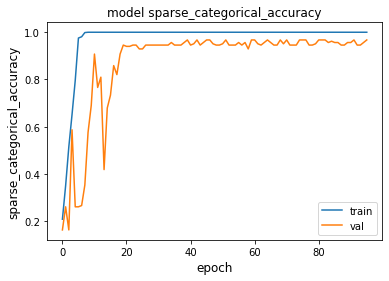

In [17]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()
